In [1]:
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, StandardScaler

file_q = h5py.File("datasets/jetnet/q.hdf5", 'r')
file_g = h5py.File("datasets/jetnet/g.hdf5", 'r')
file_w = h5py.File("datasets/jetnet/w.hdf5", 'r')
file_z = h5py.File("datasets/jetnet/z.hdf5", 'r')
file_t = h5py.File("datasets/jetnet/t.hdf5", 'r')
x_q = file_q['particle_features'][:]
x_g = file_g['particle_features'][:]
x_w = file_w['particle_features'][:]
x_z = file_z['particle_features'][:]
x_t = file_t['particle_features'][:]

y_q = np.tile([1,0,0,0,0], (x_q.shape[0], 1))
y_g = np.tile([0,1,0,0,0], (x_g.shape[0], 1))
y_w = np.tile([0,0,1,0,0], (x_w.shape[0], 1))
y_z = np.tile([0,0,0,1,0], (x_z.shape[0], 1))
y_t = np.tile([0,0,0,0,1], (x_t.shape[0], 1))

x_all = np.concatenate([x_q, x_g, x_w, x_z, x_t], axis=0)
y_all = np.concatenate([y_q, y_g, y_w, y_z, y_t], axis=0)

indices = np.arange(x_all.shape[0])
np.random.seed(42)
np.random.shuffle(indices)

x_all = x_all[indices]
y_all = y_all[indices]

n_train = 180000
n_val = 1000
#n_test = x_all.shape[0] - n_train - n_val
n_test = 200000

x_train = x_all[:n_train]
y_train = y_all[:n_train]

x_val = x_all[n_train:n_train + n_val]
y_val = y_all[n_train:n_train + n_val]

x_test = x_all[n_train + n_val:]
y_test = y_all[n_train + n_val:]

x_test = x_test[:n_test]
y_test = y_test[:n_test]

del x_all, y_all

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (180000, 30, 4)
y_train shape: (180000, 5)
x_val shape: (1000, 30, 4)
y_val shape: (1000, 5)
x_test shape: (200000, 30, 4)
y_test shape: (200000, 5)


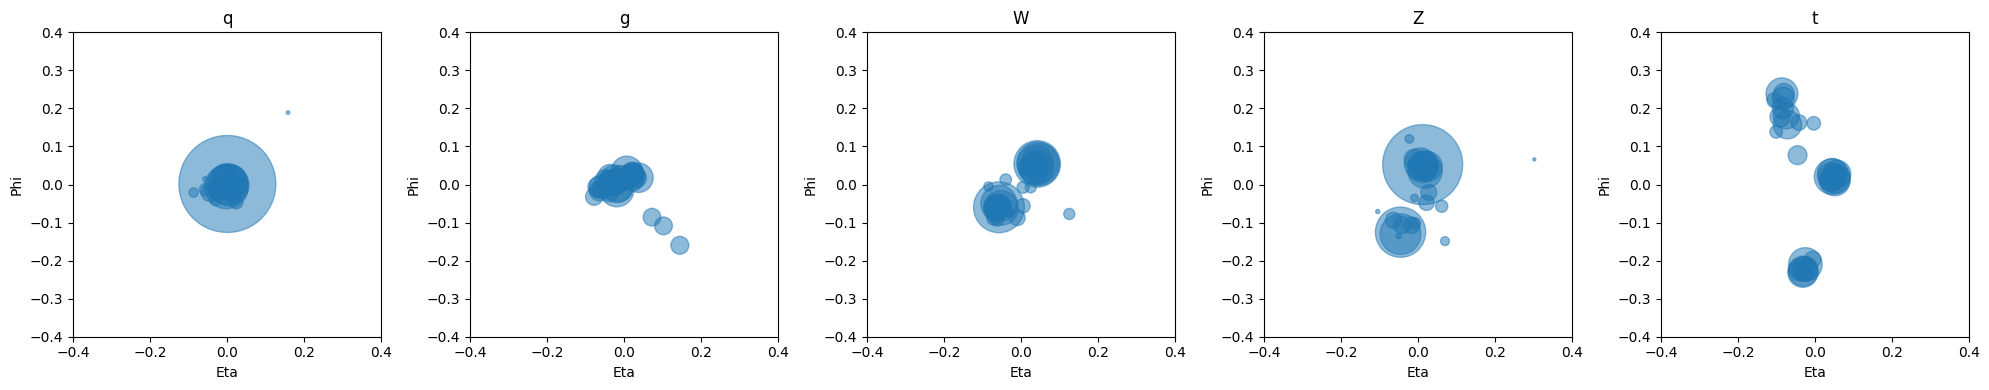

In [2]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
class_names = ['q', 'g', 'W', 'Z', 't']

for i, class_name in enumerate(class_names):
    class_idx = np.where(y_train.argmax(axis=1)==i)[0][0]
    jet = x_train[class_idx]
    eta = jet[:,0]
    phi = jet[:,1]
    pt = jet[:,2]
    mask = jet[:,3]
    
    eta = eta[mask==1]
    phi = phi[mask==1]
    pt = pt[mask==1]

    size = pt*10000

    axs[i].scatter(eta, phi, color='C0', s=size, alpha=0.5)
    axs[i].set_xlabel("Eta")
    axs[i].set_ylabel("Phi")
    axs[i].set_title(class_name)
    axs[i].set_xlim(-0.4, 0.4)
    axs[i].set_ylim(-0.4, 0.4)

plt.tight_layout()
plt.show()

In [3]:
# --- augmentations
RNG = np.random.default_rng(42)

def rotate_eta_phi(jet):
    theta = RNG.uniform(-np.pi, np.pi)
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    eta, phi, pt, valid = jet.T
    eta_r = cos_t*eta - sin_t*phi
    phi_r = sin_t*eta + cos_t*phi
    jet_r = np.vstack([eta_r, phi_r, pt, valid]).T
    return jet_r

def gaussian_smear_eta_phi(jet):
    eta, phi, pt, valid = jet.T
    sigma = 3e-4 / np.clip(pt, 1e-6, None) # 1e-4 = (QCD_scale 100 MeV) / (1 TeV); pt is particle pt / jet pt
    eta_s = eta + RNG.normal(0., sigma)
    phi_s = phi + RNG.normal(0., sigma)
    phi_s = np.where(phi_s > np.pi, phi_s - 2*np.pi,
            np.where(phi_s <= -np.pi, phi_s + 2*np.pi, phi_s))
    jet_s = np.vstack([eta_s, phi_s, pt, valid]).T
    return jet_s

def split_particles(jet):
    eta, phi, pt, valid = jet.T
    valid_idx = np.where(valid==1)[0]
    n_valid = valid_idx.size
    n_empty = 30 - n_valid
    if n_empty==0:
        return jet.copy().astype(np.float32)

    n_split  = min(n_empty, n_valid)
    to_split = RNG.choice(valid_idx, n_split, replace=False)

    extra = []
    for idx in to_split:
        a = RNG.uniform(0.3, 0.7)
        pt1 = a*pt[idx]
        pt2 = (1-a)*pt[idx]
        pt[idx] = pt1
        extra.append([eta[idx], phi[idx], pt2, 1.])

    jet_new = np.concatenate([jet, np.array(extra, dtype=np.float32)], axis=0)

    if jet_new.shape[0]<30:
        pad = np.zeros((30 - jet_new.shape[0], 4), dtype=np.float32)
        jet_new = np.concatenate([jet_new, pad], axis=0)
    return jet_new[:30].astype(np.float32)

def augment_jet(jet):
    jet = rotate_eta_phi(jet)
    jet = gaussian_smear_eta_phi(jet)
    jet = split_particles(jet)
    return jet.astype(np.float32) 

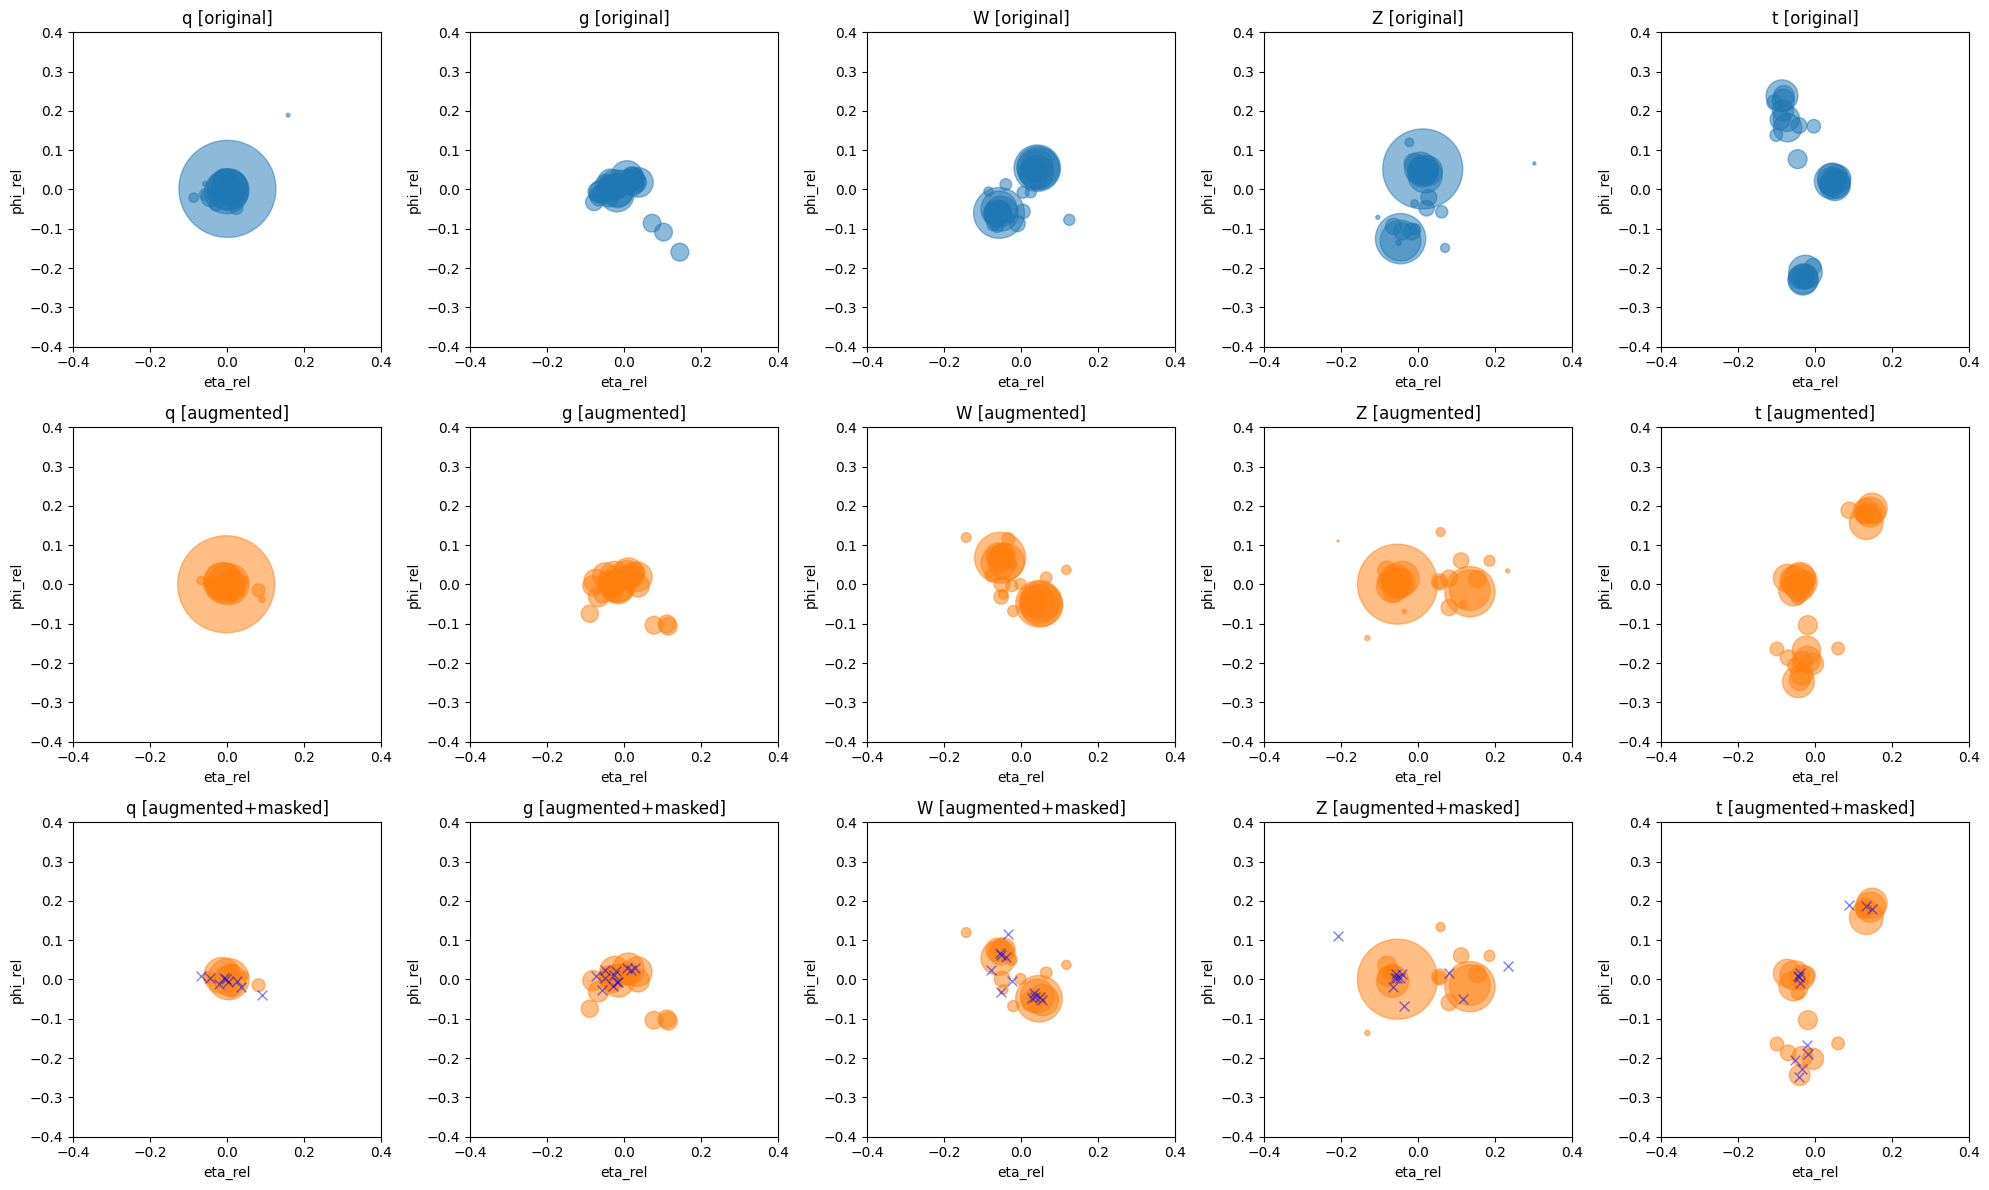

In [4]:
RNG = np.random.default_rng(42)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
class_names = ['q', 'g', 'W', 'Z', 't']
mask_ratio = 0.4

for col, cname in enumerate(class_names):
    idx = np.where(y_train.argmax(axis=1)==col)[0][0]
    jet_orig = x_train[idx]

    # original
    eta, phi, pt, valid = jet_orig.T
    axes[0, col].scatter(eta[valid==1], phi[valid==1], color='C0', s=pt[valid==1]*1e4, alpha=0.5)
    axes[0, col].set_title(f"{cname} [original]")

    # augmented
    jet_aug = augment_jet(jet_orig)
    eta, phi, pt, valid = jet_aug.T
    axes[1, col].scatter(eta[valid==1], phi[valid==1], color='C1', s=pt[valid==1]*1e4, alpha=0.5)
    axes[1, col].set_title(f"{cname} [augmented]")

    # augmented + masks
    eta, phi, pt, valid = jet_aug.T
    valid_idx = np.where(valid==1)[0]
    n_valid = valid_idx.size
    n_mask = max(1, int(np.ceil(mask_ratio * n_valid)))
    mask_idx = RNG.choice(valid_idx, n_mask, replace=False)

    mask_bool = np.zeros_like(pt, dtype=bool)
    mask_bool[mask_idx] = True

    pt_masked = pt.copy()
    pt_masked[mask_bool] = 0

    unmasked = (valid==1) & (~mask_bool)
    masked = (valid==1) & mask_bool

    axes[2, col].scatter(eta[unmasked], phi[unmasked], color='C1', s=pt_masked[unmasked]*1e4, alpha=0.5)
    axes[2, col].scatter(eta[masked], phi[masked], marker='x', color='blue', s=50, linewidths=1, alpha=0.5)
    axes[2, col].set_title(f"{cname} [augmented+masked]")

    for row in range(3):
        axes[row, col].set_xlim(-0.4, 0.4)
        axes[row, col].set_ylim(-0.4, 0.4)
        axes[row, col].set_xlabel("eta_rel")
        axes[row, col].set_ylabel("phi_rel")

plt.tight_layout()
plt.show()

## build ibot model

In [5]:
class AddClsToken(Layer):
    # add [CLS] token: (batch, n_tokens, d_model) -> (batch, n_tokens+1, d_model)
    def __init__(self, d_model, **kw):
        super().__init__(**kw)
        self.cls = self.add_weight("cls_token", shape=(1, 1, d_model), initializer="zeros", trainable=True)

    def call(self, x):
        # tile along the batch dimension
        cls_token = tf.tile(self.cls, [tf.shape(x)[0], 1, 1])
        return tf.concat([cls_token, x], axis=1)

class TransformerBlock(Layer):
    def __init__(self, d_model, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.mha = MultiHeadAttention(n_heads, d_model//n_heads)
        self.ln1 = LayerNormalization(epsilon=1e-6)
        self.ln2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([Dense(4*d_model, activation='relu'), Dense(d_model)])
        self.drop1 = Dropout(0.2)
        self.drop2 = Dropout(0.2)

    def call(self, x):
        attn_out = self.mha(x, x)
        attn_out = self.ln1(x + self.drop1(attn_out))

        ffn_out = self.ffn(attn_out)
        ffn_out = self.ln2(attn_out + self.drop2(ffn_out))
        return ffn_out

def build_backbone(d_model, n_heads, n_layers, name="backbone"):
    x_in = keras.Input((30, 4), name='particles_in') 

    # linear projection for token embedding
    x = Dense(d_model, name="token_embedding")(x_in)

    # prepend [CLS] token
    x = AddClsToken(d_model, name="prepend_cls")(x)

    # transformer blocks
    for i in range(n_layers):
        x = TransformerBlock(d_model, n_heads, name=f"block_{i}")(x)

    # split CLS and patch (particle) outputs
    cls_out = x[:, 0]
    particle_out = x[:, 1:]
    return keras.Model(x_in, [cls_out, particle_out], name=name)

def build_proj_head(d_in, d_proj, name):
    head = keras.Sequential([
        Dense(d_proj, activation='relu'),
        Dense(d_proj),
        Lambda(lambda t: tf.math.l2_normalize(t, -1))
    ], name=name)
    head.build((None, None, d_in))
    return head

d_model=80
n_heads=3
n_layers=3
d_proj=64

student = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)
teacher = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)

proj_head_s = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_student")
proj_head_t = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_teacher")

teacher.set_weights(student.get_weights())
proj_head_t.set_weights(proj_head_s.get_weights())
teacher.trainable = False
proj_head_t.trainable = False

print(student.summary())
print(proj_head_s.summary())

Model: "backbone"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 particles_in (InputLayer)   [(None, 30, 4)]              0         []                            
                                                                                                  
 token_embedding (Dense)     (None, 30, 80)               400       ['particles_in[0][0]']        
                                                                                                  
 prepend_cls (AddClsToken)   (None, 31, 80)               80        ['token_embedding[0][0]']     
                                                                                                  
 block_0 (TransformerBlock)  (None, 31, 80)               77194     ['prepend_cls[0][0]']         
                                                                                           

In [6]:
# --- wrappers for tf.data
def tf_augment_batch(jets):
    def aug_(j):
        out = tf.numpy_function(augment_jet, [j], tf.float32)
        out.set_shape((30, 4))
        return out
    return tf.map_fn(aug_, jets, fn_output_signature=tf.TensorSpec((30,4), tf.float32))

def tf_mask_batch(jets, pT_mask_token, mask_ratio_ibot):
    def mask_(jet):
        eta, phi, pt, valid = tf.unstack(jet, axis=1)
        valid_idx = tf.where(tf.equal(valid, 1.))[:,0]
        n_valid = tf.size(valid_idx)
        n_mask = tf.maximum(1, tf.cast(tf.math.ceil(mask_ratio_ibot * tf.cast(n_valid, tf.float32)), tf.int32))
        mask_idx = tf.random.shuffle(valid_idx)[:n_mask]

        mask_bool = tf.scatter_nd(tf.expand_dims(mask_idx,1), tf.ones_like(mask_idx, tf.bool), [30])
        pt_masked = tf.where(mask_bool, pT_mask_token * tf.ones_like(pt), pt)
        jet_out = tf.stack([eta, phi, pt_masked, valid], axis=1)
        return jet_out, mask_bool

    jets_masked, masks = tf.map_fn(mask_, jets, fn_output_signature=(tf.TensorSpec((30,4), tf.float32), tf.TensorSpec((30,), tf.bool)))
    return jets_masked, masks

# --- centering for teacher logits
def update_center(tok_cls, tok_patch, center_cls, center_patch, center_beta):
    center_cls.assign(center_beta * center_cls + (1 - center_beta) * tf.reduce_mean(tok_cls, axis=0))
    center_patch.assign(center_beta * center_patch + (1 - center_beta) * tf.reduce_mean(tok_patch, axis=[0, 1]))

# --- loss def
def softmax_temp(x, t):
    return tf.nn.softmax(x/t, axis=-1)

def ce_teacher_student(t_logits, s_logits, temp_t=0.04, temp_s=0.1):
    p_t = tf.stop_gradient(softmax_temp(t_logits, temp_t))
    log_p_s = tf.nn.log_softmax(s_logits / temp_s, axis=-1)
    cross_entropy = -tf.reduce_mean(tf.reduce_sum(p_t * log_p_s, axis=-1))
    return cross_entropy

def ibot_loss(cls_s, cls_t, patch_s, patch_t, mask_bool, center_cls, center_patch):
    # CLS
    loss_cls = ce_teacher_student(cls_t - center_cls, cls_s)

    # masked tokens
    float_mask = tf.cast(mask_bool, tf.float32)[..., None]
    patch_s = patch_s * float_mask
    patch_t = (patch_t - center_patch) * float_mask

    # flatten everything
    patch_s_flat = tf.reshape(patch_s, [-1, d_proj])
    patch_t_flat = tf.reshape(patch_t, [-1, d_proj])
    bool_flat  = tf.reshape(mask_bool, [-1])

    # keep only masked positions
    patch_s_sel = tf.boolean_mask(patch_s_flat, bool_flat)
    patch_t_sel = tf.boolean_mask(patch_t_flat, bool_flat)

    loss_tok = ce_teacher_student(patch_t_sel, patch_s_sel)
    return loss_cls + loss_tok, loss_cls, loss_tok

In [7]:
def train_ibot(x_train, epochs, batch_size, optimizer, ema_tau, student, teacher, proj_head_s, proj_head_t, mask_ratio_ibot, pT_mask_token, center_cls, center_patch, center_beta, temp_t, temp_s):
    def ema_update(ema_tau=ema_tau):
        for s, t in zip(student.trainable_variables, teacher.variables):
            t.assign(ema_tau*t + (1-ema_tau)*s)
        for s, t in zip(proj_head_s.trainable_variables, proj_head_t.variables):
            t.assign(ema_tau*t + (1-ema_tau)*s)

    @tf.function
    def train_step(ds_jets, optimizer, student, teacher, proj_head_s, proj_head_t, pT_mask_token):
        # two augmented views u, v
        jet_u = tf_augment_batch(ds_jets)
        jet_v = tf_augment_batch(ds_jets)

        with tf.GradientTape() as tape:
            jet_u_masked, mask_u = tf_mask_batch(jet_u, pT_mask_token, mask_ratio_ibot=mask_ratio_ibot)
            jet_v_masked, mask_v = tf_mask_batch(jet_v, pT_mask_token, mask_ratio_ibot=mask_ratio_ibot)

            # student: masked jets
            cls_u_s, patch_u_s = student(jet_u_masked, training=True)
            cls_v_s, patch_v_s = student(jet_v_masked, training=True)
            cls_u_s = proj_head_s(cls_u_s)
            cls_v_s = proj_head_s(cls_v_s)
            patch_u_s = proj_head_s(patch_u_s)
            patch_v_s = proj_head_s(patch_v_s)

            # teacher: unmasked jets (no grads)
            cls_u_t, patch_u_t = teacher(jet_u, training=False)
            cls_v_t, patch_v_t = teacher(jet_v, training=False)
            cls_u_t = proj_head_t(cls_u_t)
            cls_v_t = proj_head_t(cls_v_t)
            patch_u_t = proj_head_t(patch_u_t)
            patch_v_t = proj_head_t(patch_v_t)

            # loss
            loss_uv, loss_cls_uv, loss_patch_uv = ibot_loss(cls_s=cls_u_s, cls_t=cls_v_t,
                                                            patch_s=patch_u_s, patch_t=patch_v_t,
                                                            mask_bool=mask_u,
                                                            center_cls=center_cls, center_patch=center_patch)
            loss_vu, loss_cls_vu, loss_patch_vu = ibot_loss(cls_s=cls_v_s, cls_t=cls_u_t,
                                                            patch_s=patch_v_s, patch_t=patch_u_t,
                                                            mask_bool=mask_v,
                                                            center_cls=center_cls, center_patch=center_patch)
            loss = 0.5*(loss_uv + loss_vu)
            loss_cls = 0.5*(loss_cls_uv + loss_cls_vu)
            loss_patch = 0.5*(loss_patch_uv + loss_patch_vu)

        vars_ = (student.trainable_variables + proj_head_s.trainable_variables + [pT_mask_token])
        grads = tape.gradient(loss, vars_)
        optimizer.apply_gradients(zip(grads, vars_))

        # teacher entropy
        z_t = tf.concat([cls_u_t, cls_v_t], axis=0)
        prob_t = tf.nn.softmax((z_t - center_cls)[...]/temp_t, axis=-1)
        entropy_teacher = -tf.reduce_mean(tf.reduce_sum(prob_t * tf.math.log(prob_t + 1e-9), axis=-1))

        # student entropy
        prob_s = tf.nn.softmax((cls_u_s + cls_v_s)/2 / temp_s, axis=-1)
        entropy_student = -tf.reduce_mean(tf.reduce_sum(prob_s * tf.math.log(prob_s + 1e-9), axis=-1))

        # update centers for teacher logits
        update_center(tok_cls=tf.stop_gradient(tf.concat([cls_u_t, cls_v_t], 0)),
                      tok_patch=tf.stop_gradient(tf.concat([patch_u_t, patch_v_t], 0)),
                      center_cls=center_cls, center_patch=center_patch, center_beta=center_beta)
        return loss, loss_cls, loss_patch, entropy_teacher, entropy_student

    history = {
        "loss_total":[], "loss_cls":[], "loss_patch":[],
        "entropy_teacher":[], "entropy_student":[],
        "center_cls":[], "center_patch":[],
        "mask_token":[]
    }

    ds = (tf.data.Dataset.from_tensor_slices(x_train.astype("float32"))
          .shuffle(x_train.shape[0], seed=42)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))

    for epoch in range(epochs):
        ema_tau_waved = 1 - (1-ema_tau)*(1+math.cos(math.pi*epoch/epochs))/2
        L_total, L_cls, L_patch, E_teacher, E_student = [], [], [], [], []
        for ds_jets in ds:
            l_total, l_cls, l_patch, e_teacher, e_student = train_step(ds_jets=ds_jets,
                                                                       optimizer=optimizer,
                                                                       student=student,
                                                                       teacher=teacher,
                                                                       proj_head_s=proj_head_s,
                                                                       proj_head_t=proj_head_t,
                                                                       pT_mask_token=pT_mask_token)
            ema_update(ema_tau_waved)
            L_total.append(l_total.numpy())
            L_cls.append(l_cls.numpy())
            L_patch.append(l_patch.numpy())
            E_teacher.append(e_teacher.numpy())
            E_student.append(e_student.numpy())

        history["loss_total"].append(np.mean(L_total))
        history["loss_cls"].append(np.mean(L_cls))
        history["loss_patch"].append(np.mean(L_patch))
        history["entropy_teacher"].append(np.mean(E_teacher))
        history["entropy_student"].append(np.mean(E_student))
        history["center_cls"].append(np.linalg.norm(center_cls.numpy()))
        history["center_patch"].append(np.linalg.norm(center_patch.numpy()))
        history["mask_token"].append(pT_mask_token.numpy())

        print(f"epoch {epoch+1}/{epochs} | "
        f"loss(total)={history['loss_total'][-1]:.4f}; "
        f"loss(cls)={history['loss_cls'][-1]:.4f}; "
        f"loss(patch)={history['loss_patch'][-1]:.4f}; "
        f"entropy(teacher)={history['entropy_teacher'][-1]:.3f}; "
        f"entropy(student)={history['entropy_student'][-1]:.3f}; "
        f"norm(center_cls)={history['center_cls'][-1]:.2f}; "
        f"norm(center_patch)={history['center_patch'][-1]:.2f}; "
        f"mask_token={history['mask_token'][-1]:.3e}")
    return history

pT_mask_token = tf.Variable(0., trainable=True, name="mask_pt_token")
center_cls = tf.Variable(tf.zeros([d_proj]), trainable=False)
center_patch = tf.Variable(tf.zeros([d_proj]), trainable=False)

history_ibot_5class = train_ibot(x_train=x_train,
                                 epochs=30,
                                 batch_size=256,
                                 #optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=4e-3),
                                 optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
                                 ema_tau=0.996,
                                 student=student,
                                 teacher=teacher,
                                 proj_head_s=proj_head_s,
                                 proj_head_t=proj_head_t,
                                 mask_ratio_ibot=0.4,
                                 pT_mask_token=pT_mask_token,
                                 center_cls=center_cls,
                                 center_patch=center_patch,
                                 center_beta=0.9,
                                 temp_t=0.04,
                                 temp_s=0.1)

epoch 1/30 | loss(total)=6.9741; loss(cls)=3.4604; loss(patch)=3.5137; entropy(teacher)=3.423; entropy(student)=3.438; norm(center_cls)=0.80; norm(center_patch)=0.79; mask_token=1.218e-02
epoch 2/30 | loss(total)=7.0544; loss(cls)=3.4813; loss(patch)=3.5731; entropy(teacher)=3.480; entropy(student)=3.486; norm(center_cls)=0.78; norm(center_patch)=0.79; mask_token=1.419e-02
epoch 3/30 | loss(total)=7.0638; loss(cls)=3.4863; loss(patch)=3.5776; entropy(teacher)=3.486; entropy(student)=3.491; norm(center_cls)=0.77; norm(center_patch)=0.78; mask_token=1.418e-02
epoch 4/30 | loss(total)=7.0629; loss(cls)=3.4863; loss(patch)=3.5766; entropy(teacher)=3.486; entropy(student)=3.491; norm(center_cls)=0.78; norm(center_patch)=0.80; mask_token=1.490e-02
epoch 5/30 | loss(total)=6.9266; loss(cls)=3.4865; loss(patch)=3.4401; entropy(teacher)=3.486; entropy(student)=3.491; norm(center_cls)=0.79; norm(center_patch)=0.81; mask_token=1.788e-02
epoch 6/30 | loss(total)=6.5375; loss(cls)=3.4842; loss(patc

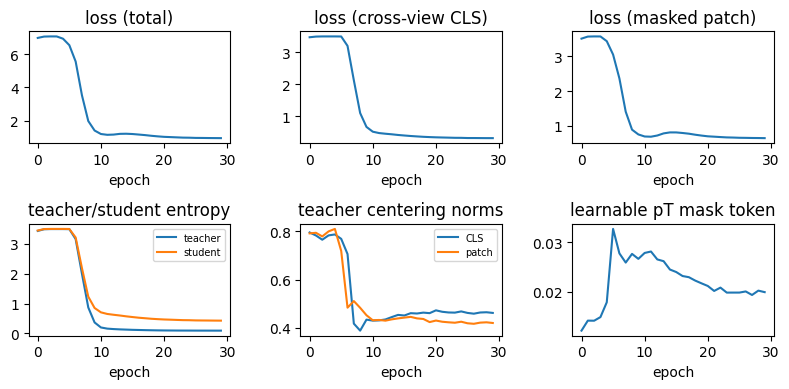

In [8]:
def plot_ibot_training(history):
    fig, ax = plt.subplots(2, 3, figsize=(8, 4), sharex=False)
    ax[0,0].plot(history["loss_total"])
    ax[0,0].set_title("loss (total)")
    ax[0,0].set_xlabel("epoch")

    ax[0,1].plot(history["loss_cls"])
    ax[0,1].set_title("loss (cross-view CLS)")
    ax[0,1].set_xlabel("epoch")

    ax[0,2].plot(history["loss_patch"])
    ax[0,2].set_title("loss (masked patch)")
    ax[0,2].set_xlabel("epoch")

    ax[1,0].plot(history["entropy_teacher"], label="teacher")
    ax[1,0].plot(history["entropy_student"], label="student")
    ax[1,0].set_title("teacher/student entropy")
    ax[1,0].set_xlabel("epoch")
    ax[1,0].legend(fontsize=7)

    ax[1,1].plot(history["center_cls"], label="CLS")
    ax[1,1].plot(history["center_patch"], label="patch")
    ax[1,1].set_title("teacher centering norms")
    ax[1,1].set_xlabel("epoch")
    ax[1,1].legend(fontsize=7)

    ax[1,2].plot(history["mask_token"])
    ax[1,2].set_title("learnable pT mask token")
    ax[1,2].set_xlabel("epoch")
    plt.tight_layout()
    plt.show()

plot_ibot_training(history_ibot_5class)

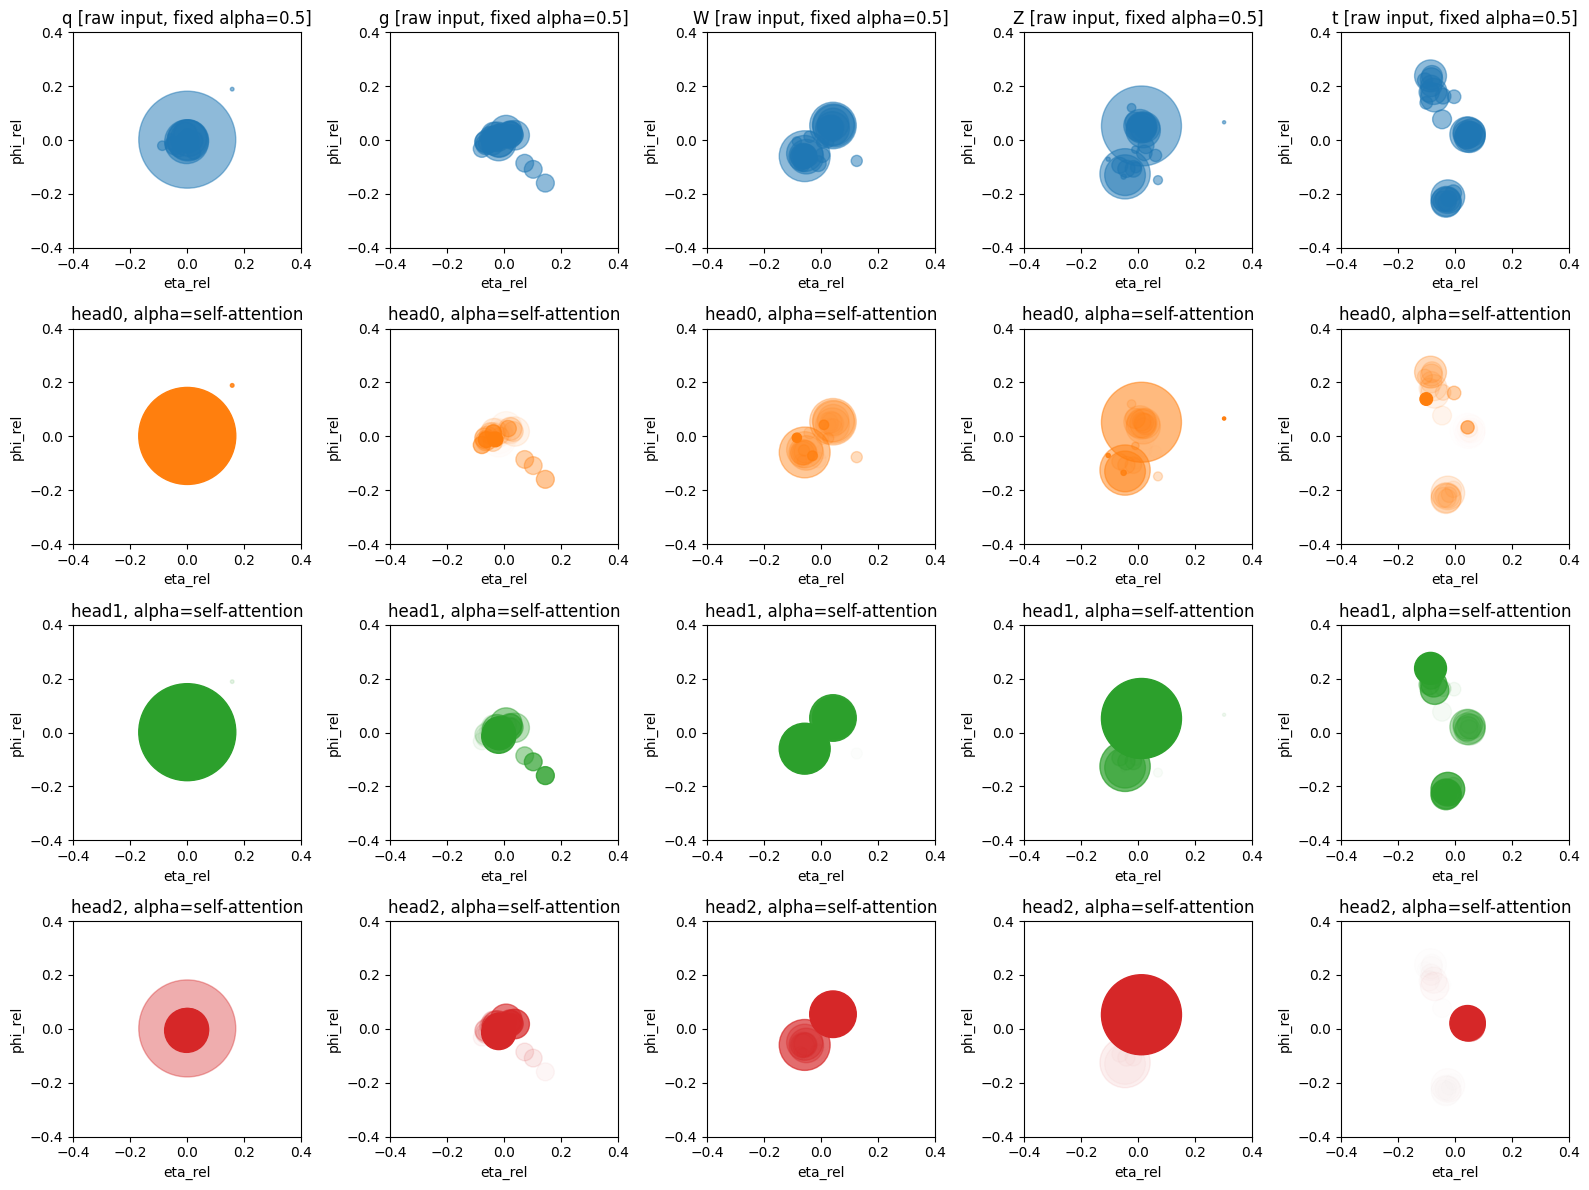

In [9]:
def plot_attention(transformer, n_heads, n_layers):
    last_block = transformer.get_layer(f"block_{n_layers-1}")
    mha_last = last_block.mha
    #heads = getattr(mha_last, "num_heads", getattr(mha_last, "_num_heads"))

    # rebuild model with attention scores as output
    x_in = transformer.input
    x = transformer.get_layer("token_embedding")(x_in)
    x = transformer.get_layer("prepend_cls")(x)
    for i in range(n_layers-1):
        x = transformer.get_layer(f"block_{i}")(x)
    _, attn_scores = mha_last(x, x, return_attention_scores=True)
    model_re = tf.keras.Model(x_in, attn_scores)

    class_names = ['q', 'g', 'W', 'Z', 't']
    rows = 1 + n_heads
    fig, axes = plt.subplots(rows, 5, figsize=(16, 3*rows))

    for col, cname in enumerate(class_names):
        idx = np.where(y_train.argmax(axis=1)==col)[0][0]
        jet = x_train[idx][None, ...].astype("float32") # (1,30,4)
        scores = model_re(jet).numpy()[0] # (n_heads, 31, 31)
        QUERYcls_KEYpatch = scores[:, 0, 1:] # (n_heads, 30)

        eta, phi, pt, valid = jet[0].T
        eta, phi, pt = eta[valid==1], phi[valid==1], pt[valid==1]
        QUERYcls_KEYpatch = QUERYcls_KEYpatch[:, valid==1]

        ax0 = axes[0, col]
        ax0.scatter(eta, phi, color="C0", s=pt*1e4, alpha=0.5)
        ax0.set_title(f"{cname} [raw input, fixed alpha=0.5]")
        ax0.set_xlim(-0.4, 0.4)
        ax0.set_ylim(-0.4, 0.4)

        for h in range(n_heads):
            w = QUERYcls_KEYpatch[h]
            w = (w - w.min())/(w.ptp() + 1e-8) # normalized
            ax = axes[1+h, col]
            ax.scatter(eta, phi, color=f"C{h+1}", s=pt*1e4, alpha=w)
            if col==0: ax.set_ylabel(f"head {h}")
            ax.set_title(f"head{h}, alpha=self-attention")
            ax.set_xlim(-0.4, 0.4)
            ax.set_ylim(-0.4, 0.4)

    for r in range(rows):
        for c in range(5):
            axes[r,c].set_xlabel("eta_rel")
            axes[r,c].set_ylabel("phi_rel")

    plt.tight_layout()
    plt.show()

plot_attention(transformer=student, n_heads=n_heads, n_layers=n_layers)

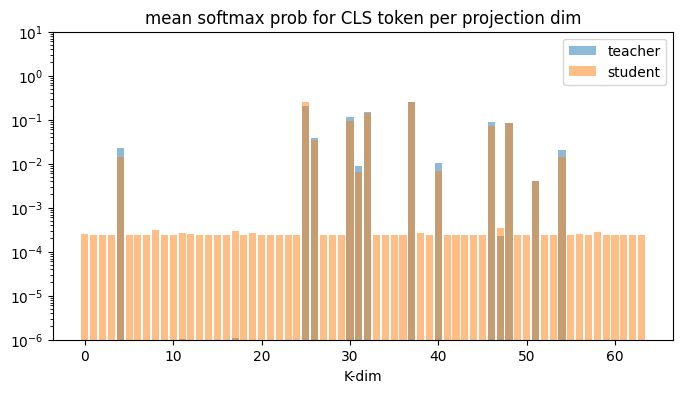

In [10]:
def plot_softmax_prob_cls(n_samples, student, teacher, proj_head_s, proj_head_t, center_cls, temp_t, temp_s):
    x_sample = x_test[:n_samples].astype("float32")
    z_teacher = proj_head_t(teacher(x_sample)[0])
    prob_t = tf.nn.softmax((z_teacher-center_cls)/temp_t, axis=-1)
    mean_prob_t = tf.reduce_mean(prob_t, axis=0).numpy()

    z_student = proj_head_s(student(x_sample)[0])
    prob_s = tf.nn.softmax(z_student/temp_s, axis=-1)
    mean_prob_s = tf.reduce_mean(prob_s, axis=0).numpy()

    plt.figure(figsize=(8,4))
    plt.bar(np.arange(d_proj), mean_prob_t, label="teacher", alpha=0.5)
    plt.bar(np.arange(d_proj), mean_prob_s, label="student", alpha=0.5)
    plt.yscale("log")
    plt.ylim(1e-6, 10)
    plt.legend()
    plt.title("mean softmax prob for CLS token per projection dim")
    plt.xlabel("K-dim")

plot_softmax_prob_cls(n_samples=5000,
                      student=student, teacher=teacher,
                      proj_head_s=proj_head_s, proj_head_t=proj_head_t,
                      center_cls=center_cls, temp_t=0.04, temp_s=0.1)

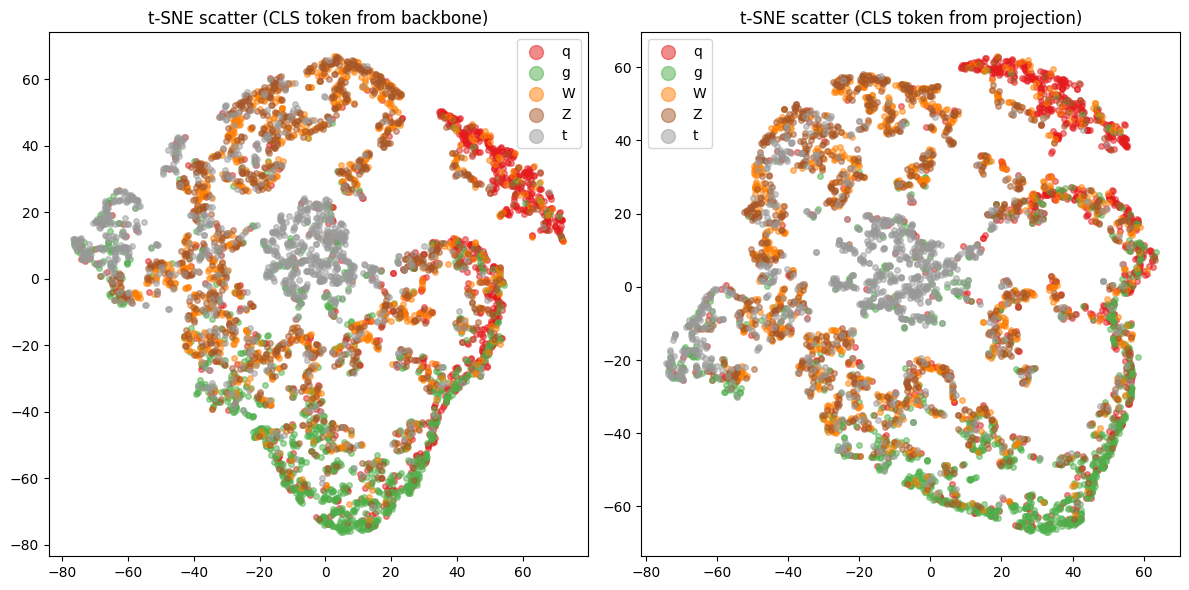

In [ ]:
def plot_tSNE_cls(n_samples, student, proj_head_s):
    x_sample = x_train[:n_samples].astype("float32")
    y_sample = y_train[:n_samples].argmax(1)
    palette = plt.cm.Set1(np.linspace(0,1,5))
    class_names = ['q', 'g', 'W', 'Z', 't']

    z_backbone = student(x_sample)[0].numpy()
    tsne_backbone = TSNE(2, random_state=42).fit_transform(z_backbone)

    if proj_head_s is not None:
        z_projection = proj_head_s(z_backbone).numpy()
        tsne_projection = TSNE(2, random_state=42).fit_transform(z_projection)

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    for k,c in enumerate(class_names):
        ax[0].scatter(tsne_backbone[y_sample==k,0], tsne_backbone[y_sample==k,1], s=16, label=c, color=palette[k], alpha=0.5)
    ax[0].set_title("t-SNE scatter (CLS token from backbone)")
    #ax[0].axis("off")
    ax[0].legend(markerscale=2.5)

    if proj_head_s is not None:
        for k,c in enumerate(class_names):
            ax[1].scatter(tsne_projection[y_sample==k,0], tsne_projection[y_sample==k,1], s=16, label=c, color=palette[k], alpha=0.5)
        ax[1].set_title("t-SNE scatter (CLS token from projection)")
        #ax[1].axis("off")
        ax[1].legend(markerscale=2.5)
    plt.tight_layout()
    plt.show()

plot_tSNE_cls(n_samples=5000, student=student, proj_head_s=proj_head_s)

In [12]:
z_cls_train = student.predict(x_train)[0]
z_cls_test = student.predict(x_test)[0]

y_train_idx = y_train.argmax(1)
y_test_idx = y_test.argmax(1)

knn = KNeighborsClassifier(n_neighbors=20).fit(z_cls_train, y_train_idx)
acc_knn = accuracy_score(y_test_idx, knn.predict(z_cls_test))

scaler = StandardScaler().fit(z_cls_train)
Z_cls_train, Z_cls_test = scaler.transform(z_cls_train), scaler.transform(z_cls_test)
logreg = LogisticRegression(max_iter=1000).fit(Z_cls_train, y_train_idx)
acc_linear = accuracy_score(y_test_idx, logreg.predict(Z_cls_test))

print(f"k-NN acc: {acc_knn:.3f}")
print(f"linear acc: {acc_linear:.3f}")

knn_p = knn.predict_proba(z_cls_test)
linear_p = logreg.predict_proba(Z_cls_test)

6250/6250 [==============================] - 72s 12ms/step
k-NN acc: 0.658
linear acc: 0.668


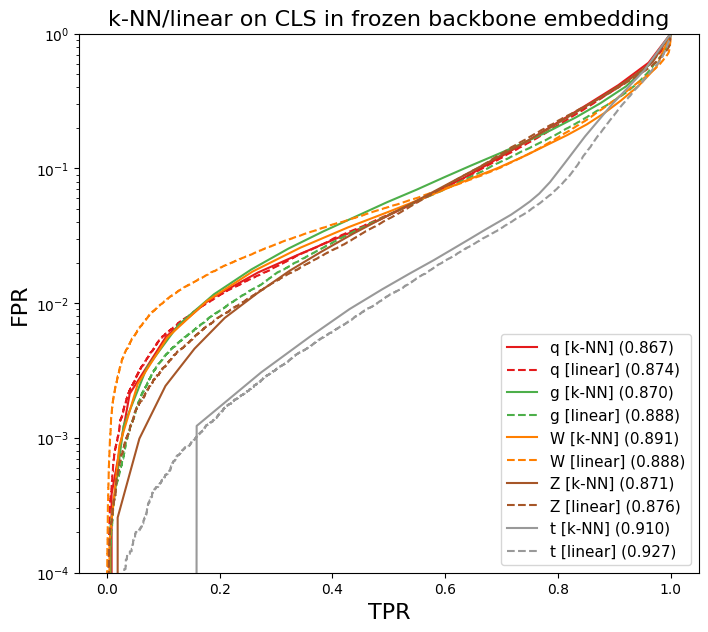

In [13]:
plt.figure(figsize=(8,7))
colors = plt.cm.Set1(np.linspace(0,1,5))
class_names = ['q','g','W','Z','t']

for k,c in enumerate(class_names):
    fpr_k, tpr_k, _ = roc_curve(y_test[:,k], knn_p[:,k])
    auc_k = auc(fpr_k, tpr_k)
    plt.plot(tpr_k, fpr_k, color=colors[k], label=f"{c} [k-NN] ({auc_k:.3f})", linestyle="-", lw=1.5)

    fpr_l, tpr_l, _ = roc_curve(y_test[:,k], linear_p[:,k])
    auc_l = auc(fpr_l, tpr_l)
    plt.plot(tpr_l, fpr_l, color=colors[k], label=f"{c} [linear] ({auc_l:.3f})", linestyle="--", lw=1.5)

plt.xlabel("TPR", size=16)
plt.ylabel("FPR", size=16)
plt.yscale("log")
plt.ylim(1e-4,1)
plt.title("k-NN/linear on CLS in frozen backbone embedding", size=16)
plt.legend(fontsize=11)
plt.show()

In [43]:
# --- classifier on backbone embedding (no fine tuning) vs standalone classifier
def build_mlp(dim_in, n_classes=5, name="mlp"):
    x_in = Input(shape=(dim_in,))
    x = Dense(dim_in*3, activation='relu')(x_in)
    x = Dropout(0.2)(x)
    x = Dense(dim_in*3, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(n_classes, activation='softmax')(x)
    return tf.keras.models.Model(x_in, x, name=name)

student.trainable = False
x_in = tf.keras.Input((30,4))
cls, _ = student(x_in)
mlp = build_mlp(d_model, name="mlp_frozen")
x_out = mlp(cls)
model = tf.keras.models.Model(x_in, x_out, name="frozen_backbone_mlp")
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

backbone_standalone = build_backbone(d_model, n_heads, n_layers, name="backbone_standalone")
mlp_standalone = build_mlp(d_model, name="mlp_standalone")
x_in = tf.keras.Input((30,4))
cls, _ = backbone_standalone(x_in)
x_out = mlp_standalone(cls)
model_standalone = tf.keras.models.Model(x_in, x_out, name="standalone_backbone_mlp")
model_standalone.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

epochs = 30
batch = 256
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch)
model_standalone.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch)

Epoch 1/30
704/704 [==============================] - 29s 41ms/step - loss: 1.0565 - accuracy: 0.5900 - val_loss: 0.9488 - val_accuracy: 0.6510
Epoch 2/30
704/704 [==============================] - 28s 39ms/step - loss: 1.0100 - accuracy: 0.6116 - val_loss: 0.9448 - val_accuracy: 0.6510
Epoch 3/30
704/704 [==============================] - 27s 38ms/step - loss: 1.0011 - accuracy: 0.6145 - val_loss: 0.9425 - val_accuracy: 0.6630
Epoch 4/30
704/704 [==============================] - 27s 38ms/step - loss: 0.9943 - accuracy: 0.6179 - val_loss: 0.9455 - val_accuracy: 0.6480
Epoch 5/30
704/704 [==============================] - 26s 37ms/step - loss: 0.9917 - accuracy: 0.6200 - val_loss: 0.9352 - val_accuracy: 0.6440
Epoch 6/30
704/704 [==============================] - 27s 39ms/step - loss: 0.9892 - accuracy: 0.6208 - val_loss: 0.9363 - val_accuracy: 0.6510
Epoch 7/30
704/704 [==============================] - 27s 39ms/step - loss: 0.9846 - accuracy: 0.6216 - val_loss: 0.9318 - val_accuracy:

In [45]:
backbone_ft = build_backbone(d_model, n_heads, n_layers, name="backbone_finetune")
backbone_ft.set_weights(student.get_weights())
mlp_ft = build_mlp(d_model, name="mlp_finetune")

x_in = tf.keras.Input((30,4))
cls, _ = backbone_ft(x_in)
x_out = mlp_ft(cls)
model_ft = tf.keras.models.Model(x_in, x_out, name="finetune_backbone_mlp")

model_ft.compile(optimizer=tf.keras.optimizers.legacy.Adam(2e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_ft.fit(x_train, y_train,
             validation_data=(x_val, y_val),
             epochs=2, batch_size=batch)

backbone_ft.trainable = False
model_ft.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_ft.fit(x_train, y_train,
             validation_data=(x_val, y_val),
             initial_epoch=2, epochs=epochs, batch_size=batch)

Epoch 1/2
704/704 [==============================] - 56s 78ms/step - loss: 0.8803 - accuracy: 0.6821 - val_loss: 0.7495 - val_accuracy: 0.7420
Epoch 2/2
704/704 [==============================] - 55s 78ms/step - loss: 0.7749 - accuracy: 0.7272 - val_loss: 0.7194 - val_accuracy: 0.7590
Epoch 3/30
704/704 [==============================] - 27s 38ms/step - loss: 0.7503 - accuracy: 0.7380 - val_loss: 0.7125 - val_accuracy: 0.7640
Epoch 4/30
704/704 [==============================] - 27s 38ms/step - loss: 0.7461 - accuracy: 0.7391 - val_loss: 0.7042 - val_accuracy: 0.7600
Epoch 5/30
704/704 [==============================] - 27s 39ms/step - loss: 0.7429 - accuracy: 0.7406 - val_loss: 0.7161 - val_accuracy: 0.7600
Epoch 6/30
704/704 [==============================] - 26s 37ms/step - loss: 0.7431 - accuracy: 0.7398 - val_loss: 0.7145 - val_accuracy: 0.7620
Epoch 7/30
704/704 [==============================] - 26s 37ms/step - loss: 0.7425 - accuracy: 0.7403 - val_loss: 0.7053 - val_accuracy: 0

6250/6250 [==============================] - 47s 7ms/step
acc: 0.656
finetune acc: 0.747
standalone acc: 0.737


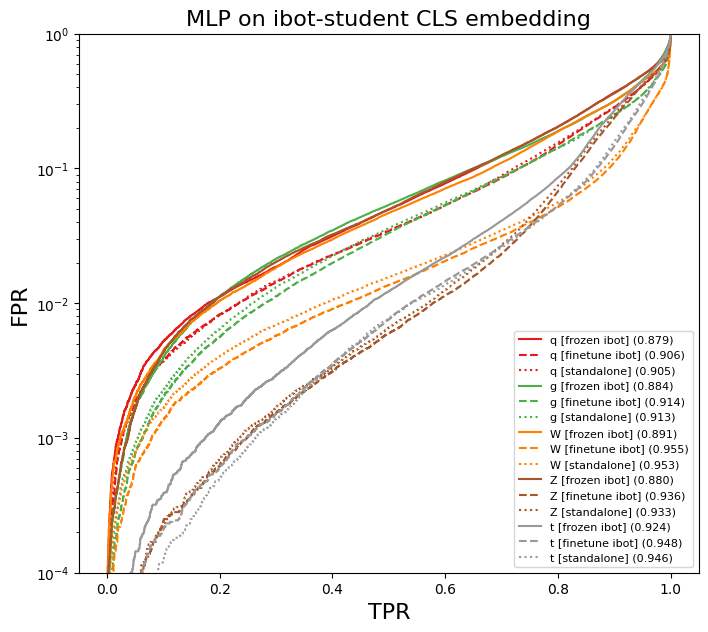

In [48]:
y_pred = model.predict(x_test)
y_pred_ft = model_ft.predict(x_test)
y_pred_standalone = model_standalone.predict(x_test)

acc_model = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
acc_ft = accuracy_score(y_test.argmax(axis=1), y_pred_ft.argmax(axis=1))
acc_standalone = accuracy_score(y_test.argmax(axis=1), y_pred_standalone.argmax(axis=1))

print(f"acc: {acc_model:.3f}")
print(f"finetune acc: {acc_ft:.3f}")
print(f"standalone acc: {acc_standalone:.3f}")

plt.figure(figsize=(8,7))
colors = plt.cm.Set1(np.linspace(0,1,5))
class_names = ['q','g','W','Z','t']

for k,c in enumerate(class_names):
    fpr_f, tpr_f, _ = roc_curve(y_test[:,k], y_pred[:,k])
    auc_f = auc(fpr_f, tpr_f)
    plt.plot(tpr_f, fpr_f, color=colors[k], lw=1.5, linestyle='-', label=f"{c} [frozen ibot] ({auc_f:.3f})")

    fpr_ft, tpr_ft, _ = roc_curve(y_test[:,k], y_pred_ft[:,k])
    auc_ft = auc(fpr_ft, tpr_ft)
    plt.plot(tpr_ft, fpr_ft, color=colors[k], lw=1.5, linestyle='--', label=f"{c} [finetune ibot] ({auc_ft:.3f})")
    
    fpr_s, tpr_s, _ = roc_curve(y_test[:,k], y_pred_standalone[:,k])
    auc_s = auc(fpr_s, tpr_s)
    plt.plot(tpr_s, fpr_s, color=colors[k], lw=1.5, linestyle='dotted', label=f"{c} [standalone] ({auc_s:.3f})")

plt.xlabel("TPR", size=16)
plt.ylabel("FPR", size=16)
plt.yscale("log")
plt.ylim(1e-4,1)
plt.title("MLP on ibot-student CLS embedding", size=16)
plt.legend(fontsize=8)
plt.show()

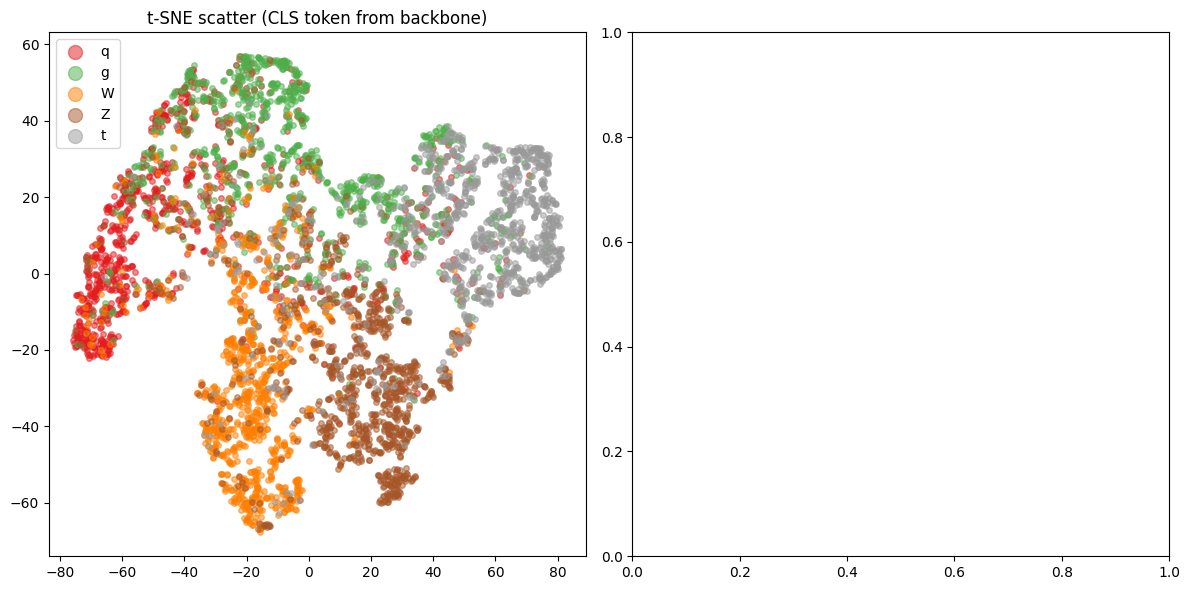

In [ ]:
plot_tSNE_cls(n_samples=5000, student=backbone_ft, proj_head_s=None)

## AD (train ibot with q/g only)

In [20]:
#d_model=128
#n_heads=3
#n_layers=3
#d_proj=64

student_ad = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)
teacher_ad = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)

proj_head_s_ad = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_student")
proj_head_t_ad = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_teacher")

teacher_ad.set_weights(student_ad.get_weights())
proj_head_t_ad.set_weights(proj_head_s_ad.get_weights())
teacher_ad.trainable = False
proj_head_t_ad.trainable = False

print(student_ad.summary())
print(proj_head_s_ad.summary())

Model: "backbone"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 particles_in (InputLayer)   [(None, 30, 4)]              0         []                            
                                                                                                  
 token_embedding (Dense)     (None, 30, 80)               400       ['particles_in[0][0]']        
                                                                                                  
 prepend_cls (AddClsToken)   (None, 31, 80)               80        ['token_embedding[0][0]']     
                                                                                                  
 block_0 (TransformerBlock)  (None, 31, 80)               77194     ['prepend_cls[0][0]']         
                                                                                           

epoch 1/30 | loss(total)=7.0711; loss(cls)=3.5201; loss(patch)=3.5510; entropy(teacher)=3.321; entropy(student)=3.399; norm(center_cls)=0.71; norm(center_patch)=0.72; mask_token=3.261e-05
epoch 2/30 | loss(total)=6.6020; loss(cls)=3.2227; loss(patch)=3.3793; entropy(teacher)=3.207; entropy(student)=3.221; norm(center_cls)=0.68; norm(center_patch)=0.69; mask_token=3.123e-04
epoch 3/30 | loss(total)=6.6908; loss(cls)=3.2699; loss(patch)=3.4209; entropy(teacher)=3.265; entropy(student)=3.272; norm(center_cls)=0.66; norm(center_patch)=0.67; mask_token=7.744e-04
epoch 4/30 | loss(total)=6.7668; loss(cls)=3.3182; loss(patch)=3.4486; entropy(teacher)=3.315; entropy(student)=3.321; norm(center_cls)=0.67; norm(center_patch)=0.68; mask_token=2.067e-03
epoch 5/30 | loss(total)=6.8029; loss(cls)=3.3413; loss(patch)=3.4616; entropy(teacher)=3.339; entropy(student)=3.344; norm(center_cls)=0.68; norm(center_patch)=0.69; mask_token=3.850e-03
epoch 6/30 | loss(total)=6.7939; loss(cls)=3.3503; loss(patc

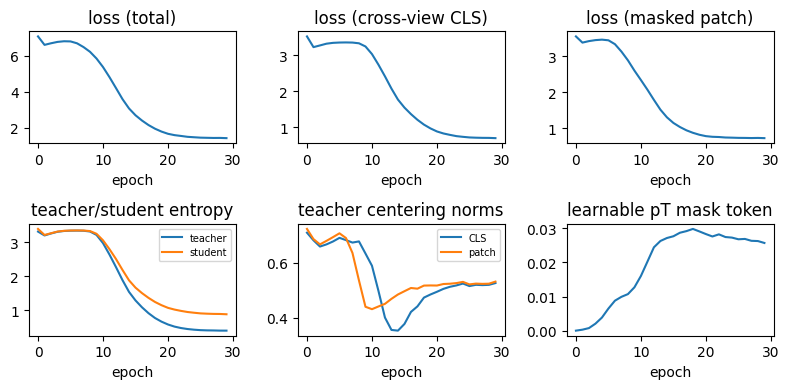

In [21]:
normal_mask_train = (y_train[:,0] + y_train[:,1])==1
anomaly_mask_train = ~normal_mask_train

x_train_normal = x_train[normal_mask_train]
x_train_anomaly = x_train[anomaly_mask_train]

pT_mask_token_ad = tf.Variable(0., trainable=True, name="mask_pt_token")
center_cls_ad = tf.Variable(tf.zeros([d_proj]), trainable=False)
center_patch_ad = tf.Variable(tf.zeros([d_proj]), trainable=False)

history_ibot_2class = train_ibot(x_train=x_train_normal,
                                 epochs=30,
                                 batch_size=256,
                                 #optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=4e-3),
                                 optimizer=tf.keras.optimizers.legacy.Adam(2e-4),
                                 ema_tau=0.996,
                                 student=student_ad,
                                 teacher=teacher_ad,
                                 proj_head_s=proj_head_s_ad,
                                 proj_head_t=proj_head_t_ad,
                                 mask_ratio_ibot=0.4,
                                 pT_mask_token=pT_mask_token_ad,
                                 center_cls=center_cls_ad,
                                 center_patch=center_patch_ad,
                                 center_beta=0.9,
                                 temp_t=0.04,
                                 temp_s=0.1)

plot_ibot_training(history_ibot_2class)

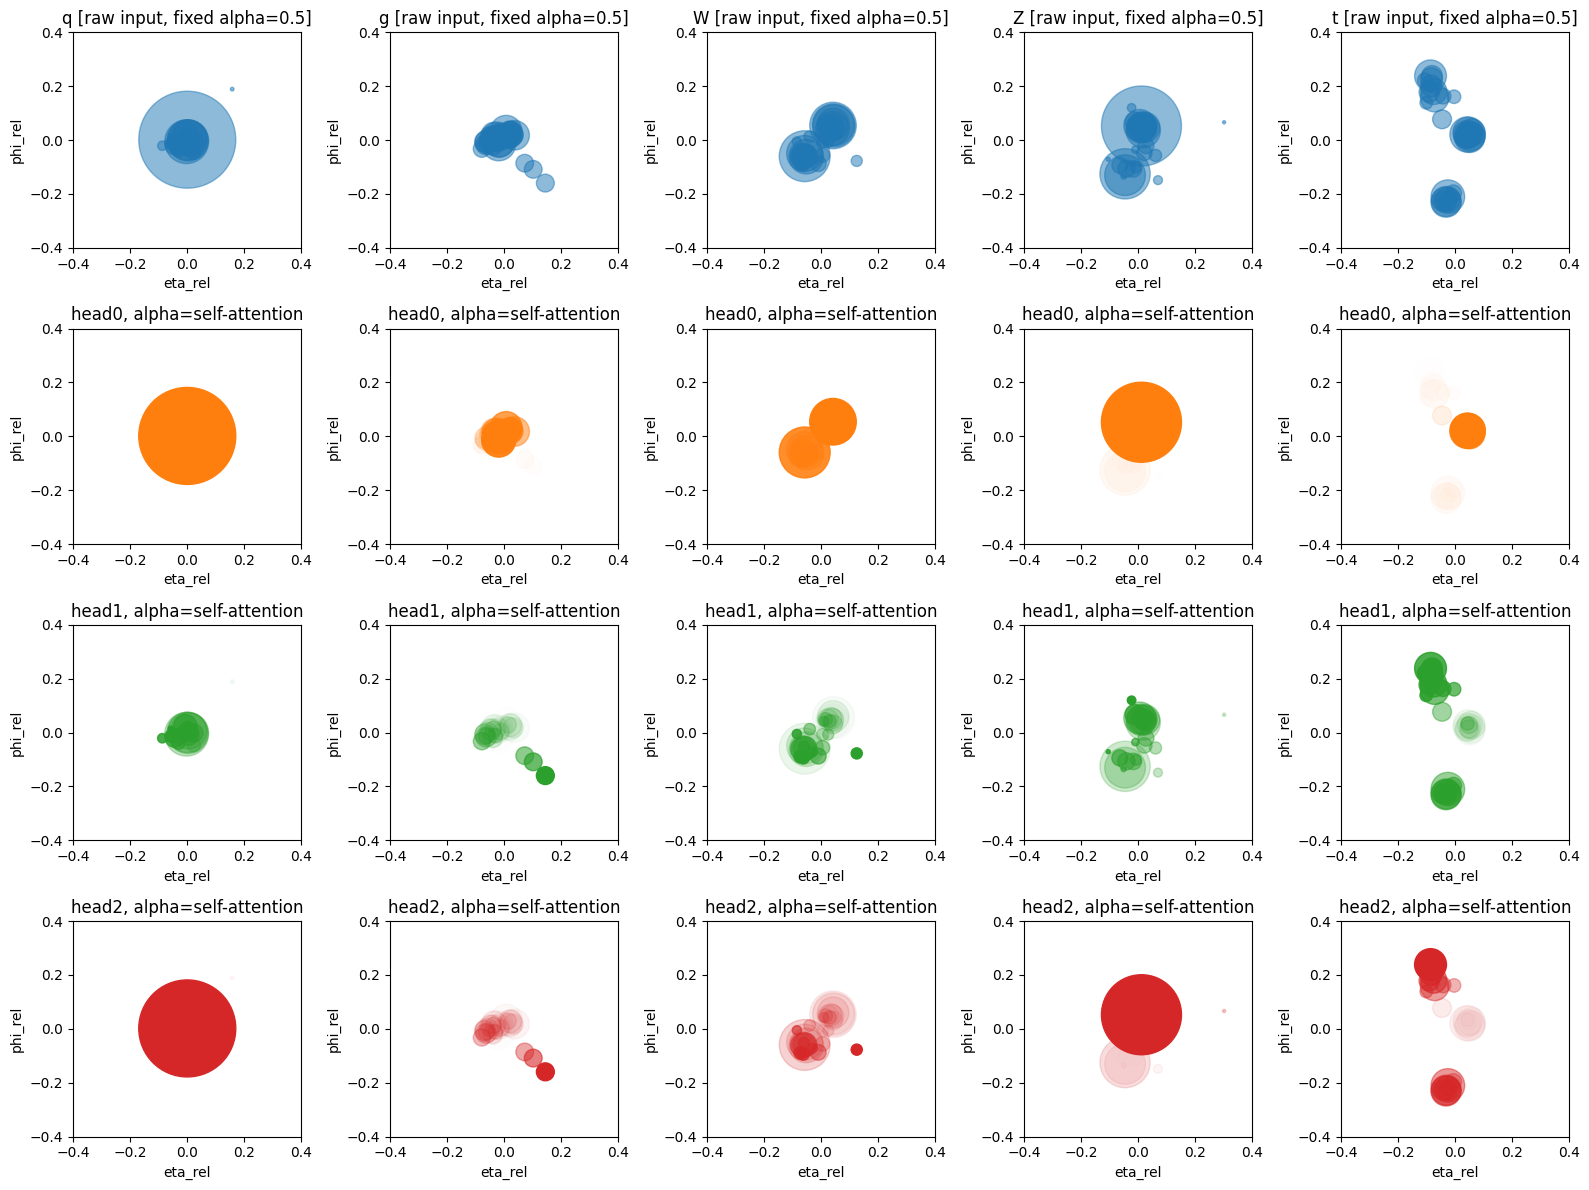

In [22]:
plot_attention(transformer=student_ad, n_heads=n_heads, n_layers=n_layers)

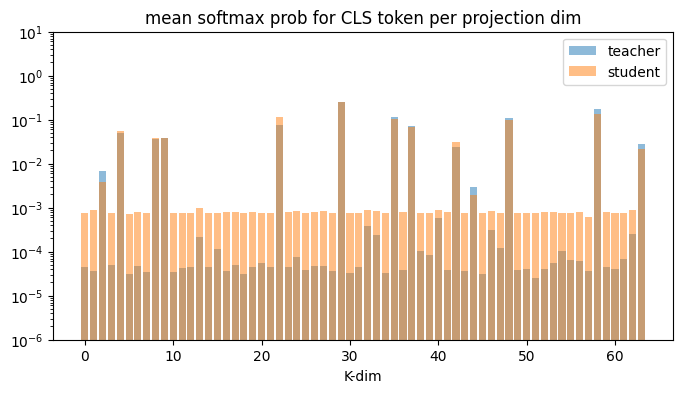

In [23]:
plot_softmax_prob_cls(n_samples=5000,
                      student=student_ad, teacher=teacher_ad,
                      proj_head_s=proj_head_s_ad, proj_head_t=proj_head_t_ad,
                      center_cls=center_cls_ad, temp_t=0.04, temp_s=0.1)

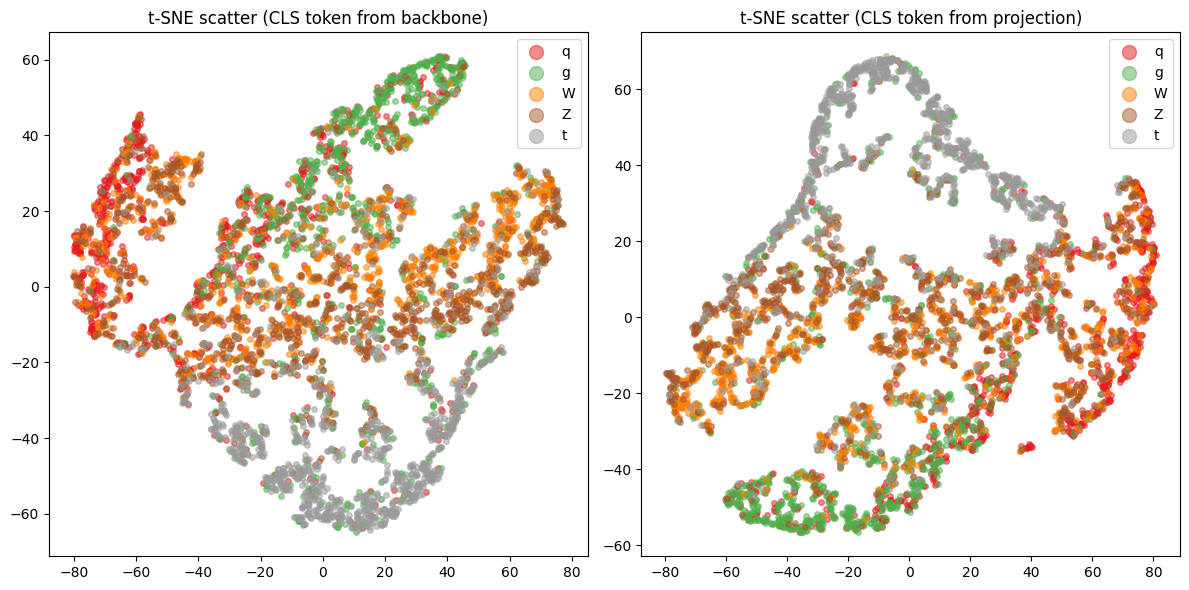

In [24]:
plot_tSNE_cls(n_samples=5000, student=student_ad, proj_head_s=proj_head_s_ad)

In [29]:
z_train_normal = student_ad.predict(x_train_normal)[0]
knn_ad_bank = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(z_train_normal)
cosim_ad_bank = z_train_normal / np.linalg.norm(z_train_normal, axis=1, keepdims=True)
M = cosim_ad_bank.shape[0]

def ad_score_knn(x, student_ad, knn_ad_bank):
    z = student_ad.predict(x)[0] 
    dist, _ = knn_ad_bank.kneighbors(z)
    return dist.mean(axis=1)

def ad_score_cosim(x, student_ad, cosim_ad_bank, sum_or_max, tau=0.04):
    z = student_ad.predict(x)[0]
    z = z / np.linalg.norm(z, axis=1, keepdims=True)
    sim = np.dot(z, cosim_ad_bank.T)
    if sum_or_max=="sum":
        return -np.mean(np.exp(sim / tau), axis=1) * 1e-10
    elif sum_or_max=="max":
        return 1-np.max(sim, axis=1) 

normal_mask_test = (y_test[:,0]==1) | (y_test[:,1]==1)
x_test_normal = x_test[normal_mask_test]
score_knn_normal = ad_score_knn(x_test_normal, student_ad, knn_ad_bank)
score_cosim_sum_normal = ad_score_cosim(x_test_normal, student_ad, cosim_ad_bank, "sum")
score_cosim_max_normal = ad_score_cosim(x_test_normal, student_ad, cosim_ad_bank, "max")

anomaly_classes = {2:'W', 3:'Z', 4:'t'}
scores_knn_anomaly = {}
scores_cosim_sum_anomaly = {}
scores_cosim_max_anomaly = {}
for i,(col,name) in enumerate(anomaly_classes.items()):
    anomaly_mask_test = y_test[:,col]==1
    x_test_anomaly = x_test[anomaly_mask_test]
    scores_knn_anomaly[name] = ad_score_knn(x_test_anomaly, student_ad, knn_ad_bank)
    scores_cosim_sum_anomaly[name] = ad_score_cosim(x_test_anomaly, student_ad, cosim_ad_bank, "sum")
    scores_cosim_max_anomaly[name] = ad_score_cosim(x_test_anomaly, student_ad, cosim_ad_bank, "max")

1266/1266 [==============================] - 13s 10ms/step


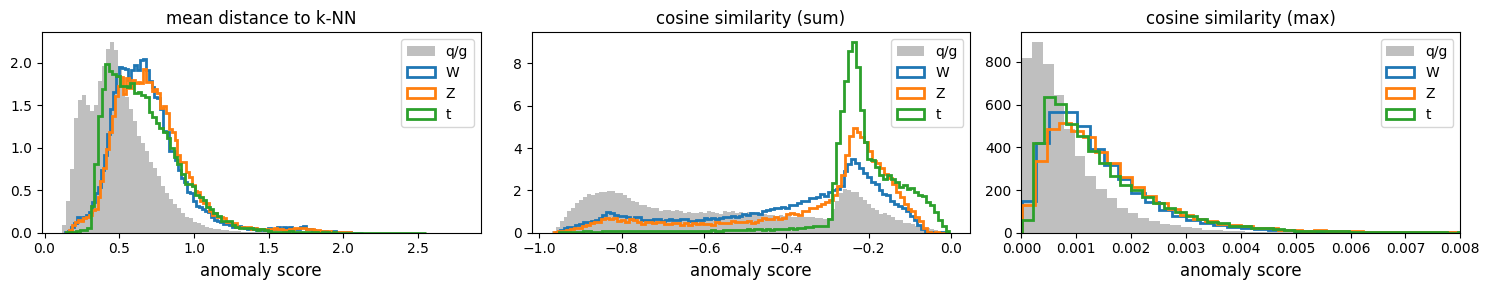

In [37]:
fig, ax = plt.subplots(1,3,figsize=(15,3))

ax[0].hist(score_knn_normal, bins=100, density=True, color='grey', alpha=0.5, label='q/g')
for (name, score), i in zip(scores_knn_anomaly.items(), range(len(scores_knn_anomaly))):
    ax[0].hist(score, bins=100, density=True, histtype='step', linewidth=2, color=f"C{i}", label=f"{name}")
ax[0].set_xlabel("anomaly score", size=12)
ax[0].set_title("mean distance to k-NN", size=12)
ax[0].legend(fontsize=10)

ax[1].hist(score_cosim_sum_normal, bins=100, density=True, color='grey', alpha=0.5, label='q/g')
for (name, score), i in zip(scores_cosim_sum_anomaly.items(), range(len(scores_cosim_sum_anomaly))):
    ax[1].hist(score, bins=100, density=True, histtype='step', linewidth=2, color=f"C{i}", label=f"{name}")
ax[1].set_xlabel("anomaly score", size=12)
ax[1].set_title("cosine similarity (sum)", size=12)
ax[1].legend(fontsize=10)

ax[2].hist(score_cosim_max_normal, bins=100, density=True, color='grey', alpha=0.5, label='q/g')
for (name, score), i in zip(scores_cosim_max_anomaly.items(), range(len(scores_cosim_max_anomaly))):
    ax[2].hist(score, bins=100, density=True, histtype='step', linewidth=2, color=f"C{i}", label=f"{name}")
ax[2].set_xlabel("anomaly score", size=12)
ax[2].set_title("cosine similarity (max)", size=12)
ax[2].set_xlim(0,0.008)
ax[2].legend(fontsize=10)

plt.tight_layout()
plt.show()

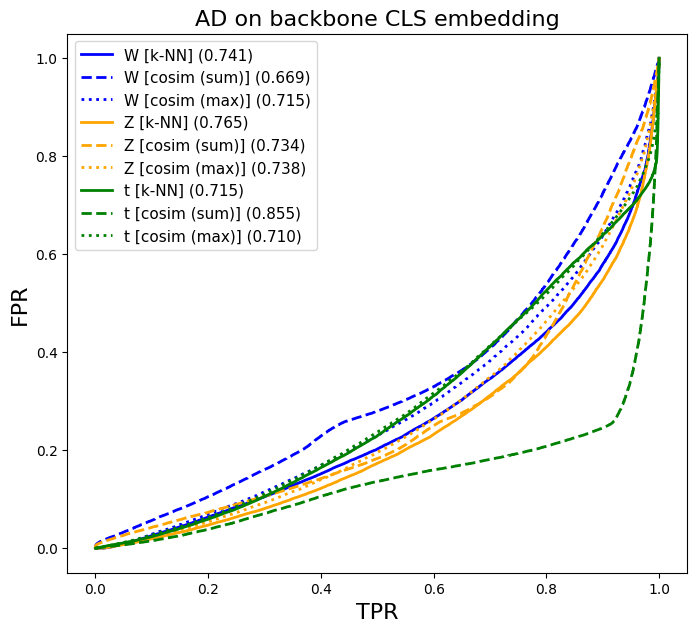

In [39]:
plt.figure(figsize=(8,7))
colors = ["blue", "orange", "green"]

for i,(col,name) in enumerate(anomaly_classes.items()):
    y_true = np.concatenate([np.zeros_like(score_knn_normal), np.ones_like(scores_knn_anomaly[name])])
    scores = np.concatenate([score_knn_normal, scores_knn_anomaly[name]])
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc_ = auc(fpr, tpr)
    plt.plot(tpr, fpr, color=colors[i], label=f"{name} [k-NN] ({auc_:.3f})", linestyle="-", lw=2)

    y_true = np.concatenate([np.zeros_like(score_cosim_sum_normal), np.ones_like(scores_cosim_sum_anomaly[name])])
    scores = np.concatenate([score_cosim_sum_normal, scores_cosim_sum_anomaly[name]])
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc_ = auc(fpr, tpr)
    plt.plot(tpr, fpr, color=colors[i], label=f"{name} [cosim (sum)] ({auc_:.3f})", linestyle="--", lw=2)

    y_true = np.concatenate([np.zeros_like(score_cosim_max_normal), np.ones_like(scores_cosim_max_anomaly[name])])
    scores = np.concatenate([score_cosim_max_normal, scores_cosim_max_anomaly[name]])
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc_ = auc(fpr, tpr)
    plt.plot(tpr, fpr, color=colors[i], label=f"{name} [cosim (max)] ({auc_:.3f})", linestyle="dotted", lw=2)

plt.xlabel("TPR", size=16)
plt.ylabel("FPR", size=16)
#plt.yscale("log")
#plt.ylim(1e-4,1)
plt.title("AD on backbone CLS embedding", size=16)
plt.legend(fontsize=11)
plt.show()